In [ ]:
!pip install networkx
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np

     |████████████████████████████████| 1.9 MB 20.5 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
G = nx.DiGraph() #define a directed graph
map_tasks = 10
reduce_tasks = 5

In [ ]:
G.add_nodes_from([i for i in range(map_tasks)]) #creates the map tasks
G.add_node(map_tasks) #barreir sync for map tasks
G.add_edges_from([(i,map_tasks) for i in range(map_tasks)])  #adding edges from map taskss to the sync node
G.add_nodes_from([i+map_tasks+1 for i in range(reduce_tasks)]) #create reduce tasks
G.add_edges_from([(map_tasks, i+map_tasks+1) for i in range(reduce_tasks)]) #add edges from the sync node to the reduce tasks
G.add_node(map_tasks+reduce_tasks+1) #final node to sync the reduce tasks
G.add_edges_from([(i+map_tasks+1, map_tasks+reduce_tasks+1) for i in range(reduce_tasks)]) #adding edges from reduce tasks to end sync node

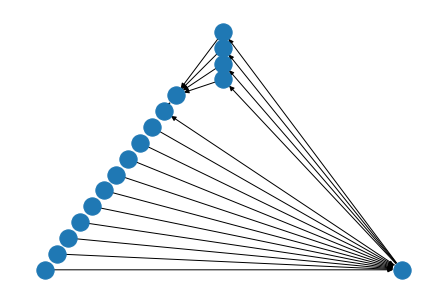

In [ ]:
nx.draw_planar(G)

[range(0, 10), range(10, 11), range(11, 16), range(16, 17)]


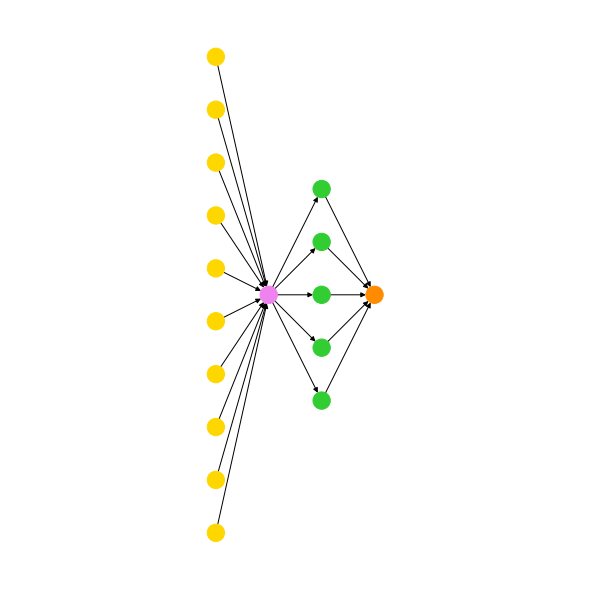

In [ ]:
subset_sizes = [map_tasks, 1, reduce_tasks, 1]
subset_color = [
    "gold",
    "violet",
    "limegreen",
    "darkorange",
]


def multilayered_graph(*subset_sizes):
    extents = nx.utils.pairwise(itertools.accumulate((0,) + subset_sizes))
    layers = [range(start, end) for start, end in extents]
    print(extents)
    print(layers)
    G = nx.DiGraph()
    for (i, layer) in enumerate(layers):
        G.add_nodes_from(layer, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G


G = multilayered_graph(*subset_sizes)
color = [subset_color[data["layer"]] for v, data in G.nodes(data=True)]
pos = nx.multipartite_layout(G, subset_key="layer")
plt.figure(figsize=(8, 8))
nx.draw(G, pos, node_color=color, with_labels=False)
plt.axis("equal")
plt.show()

In [ ]:
list(nx.topological_sort(G)) #for scheduling the tasks in the order

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [ ]:
len(G.in_edges(16, data=False)) #get the incoming edges to find the dependencies

5

In [ ]:
for k in (G[10].keys()): #get the out-edges of a task
  print(k)

11
12
13
14
15


In [ ]:
from enum import Enum
class EventType(Enum):
  TERMINATE = 1
  FAIL = 2
  STRAGGLE = 3
  COMMDONE = 4 # Communication Done

In [ ]:
class WorkerStatus(Enum):
  FREE = 1
  FAILED = 2
  BUSYCOMM = 3 # busy with communication
  BUSYCOMP = 4 # busy with computation

In [ ]:
class TaskStatus(Enum):
  COMPLETE = 1
  COMPUTING = 2
  UNASIGGNED = 3
  COMMUNICATING = 4

In [ ]:
class Task:

  def __init__(self, task_id: int = 0, 
                     task_parameters = {"task_type": "sort", "n_records": 1000}, 
                     task_status:TaskStatus=TaskStatus.COMPUTING, 
                     num_dependent_tasks=0,
                     dependency_info={},
                     dependent_task_size={}) -> None:
      # This task_id becomes the node number when we construct the task graph
      self.task_id = task_id
      self.status = task_status
      self.num_dependent_tasks = num_dependent_tasks

      self.dependency_info = {}
      self.task_parameters = task_parameters

  def debug(self):
      print("task_id: ", self.task_id)
      print("status: ", self.status)
      print("num of dependent tasks: ", self.num_dependent_tasks)
      print("parameters: ", self.task_parameters)

In [ ]:
#from traitlets.traitlets import List
from typing import List, Union
class Worker:
  def __init__(self, memory_size, network_bandwidth, disk_bandwidth, status:WorkerStatus, failure_rate, straggle_rate, task:Task = None) -> None:
      self.memory_size = memory_size
      self.network_bandwidth = network_bandwidth
      self.disk_bandwidth = disk_bandwidth
      self.status = status
      self.task = task
      self.failure_rate = failure_rate
      self.straggle_rate = straggle_rate
      

  def total_time(self):
    return self.networking_time() + self.processing_time()
    
  # https://docs.google.com/document/d/19rdGXWj-RV9rafxIQSBwoXIERgACeyMKoR5GHiMhWq0/edit#heading=h.6dzmcaotr3ns
  def processing_time(self)->List[Union[EventType,int]]:
    total_processing_time = 0

    total_processing_time += self.disk_time_for_input()
    # total_processing_time += self.memory_time_for_input()

    task_parameters = self.task.task_parameters
    # print(task_parameters)
    if task_parameters["task_type"] == "sort":
      # Nick here, also can we look at this https://read.seas.harvard.edu/cs260r/2022/project1a/ for the modeling? it says that grep almost ignores disk
      # but sort doesn't. Does the 10x ratio mostly come from the fact we get a smaller output in grep. I think eddie suggest we should look at scan rate
      # mapper grep size of output/ size of input = 605B/66.7MB = 0ish
      # mapper sort size of output/ size of input = ((500MB * 4000)/15000)/64MB = 2
      # grep network transfer/read from disk > sort network transfer/read from disk
      # the total processing time depends on whether we are on a map task or a reduce task, how do we incorporate that here? do we want to incororate that
      # here? 
      total_processing_time += task_parameters["n_records"] * np.log(task_parameters["n_records"])

    if task_parameters["task_type"] == "grep":
      total_processing_time += task_parameters["n_records"]

    
    # total_processing_time += self.memory_time_for_output()
    total_processing_time += self.disk_time_for_output()

    return [EventType.TERMINATE, total_processing_time]

  def networking_time(self):
    # TODO: Have this function actually calculate networking time given its attributes
    
    return 5

  def disk_time_for_input(self):
    # TODO: Have this function actually calculate disk time given its attributes
    # calculate input data amount from self.task and 
    return 5

  def disk_time_for_output(self):
    # TODO: Have this function actually calculate disk time given its attributes
    # calculate output data amount from self.task and 
    return 5

In [ ]:
class Event:
  def __init__(self, time =0, event_type:EventType = None, worker:Worker = None) -> None:
      self.time = time
      self.event_type = event_type 
      self.worker = worker

  def debug(self):
    print("Time: ", self.time)
    print("Event type: ", self.event_type)

  def __eq__(self, other):
      return self.time == other.time
    
  def __gt__(self, other):
      return self.time > other.time

  def __lt__(self, other):
    return self.time < other.time
    

In [ ]:
class Program():
    task_topology = []
    task_dependency_infos = {} # hashmap of tasks that stores (dependent task, dependent data amount)
    program_type = None # "sort", "grep", or etc.
    system_type = None # "mapreduce", "dask", or etc.
    def __init__(self, program_type="", system_type="", task_toplogy=[], **kwargs):
        self.program_type = program_type
        self.system_type = system_type
        self.task_topology = task_topology
        
            
        

In [ ]:
class TaskGraph(nx.DiGraph):
    def __init__(self, program):
        super().__init__()
        self.subset_color = [
            "gold",
            "violet",
            "limegreen",
            "darkorange",
        ]
        
        if program.system_type == "mapreduce":
            # task_topology = (M, R)
            M, R = program.task_topology
            layers = [range(M), range(M, M+R)]
            
            for (i, layer) in enumerate(layers):
                # list of Task objects
                if i == 0: # Map
                    task_list = [dict(task=Task(task_id=t_id)) for t_id in layer]
                else: # Reduce
                    task_list = [dict(task=Task(task_id=t_id)) for t_id in layer]
                node_list = list(zip(list(layer), task_list))
                print(node_list)
                self.add_nodes_from(node_list, layer=i)
            for layer1, layer2 in nx.utils.pairwise(layers):
                self.add_edges_from(itertools.product(layer1, layer2))

        else:
            extents = nx.utils.pairwise(itertools.accumulate((0,) + task_topology))
            print(extents)
            layers = [range(start, end) for start, end in extents]
            print(layers)
            for (i, layer) in enumerate(layers):
                # list of Task objects
                task_list = [dict(task=Task(task_id=t_id)) for t_id in layer]
                node_list = list(zip(list(layer), task_list))
                print(node_list)
                self.add_nodes_from(node_list, layer=i)
            for layer1, layer2 in nx.utils.pairwise(layers):
                self.add_edges_from(itertools.product(layer1, layer2))
        
        print(self)


    def debug(self):
        print("debugging graph\n")
        for node in self.nodes:
            self.nodes[node]["task"].debug()
    
    def print_graph(self):
        color = [subset_color[data["layer"]] for v, data in self.nodes(data=True)]
        pos = nx.multipartite_layout(self, subset_key="layer")
        plt.figure(figsize=(8, 8))
        nx.draw(self, pos, node_color=color, with_labels=False)
        plt.axis("equal")
        plt.show()

In [ ]:
# Grep task: (M=15000, R=1 in the paper, section 5.2)
print("--------------Grep task--------------")
M, R = 5, 1
task_topology = [M,M,1 R,1]
program =Program(program_type="grep", system_type="mapreduce", task_topology=task_topology)
taskG = TaskGraph(program)
#taskG.print_graph()
grep_task = Task(task_parameters={"task_type":"grep", "n_records":10})
worker = Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=grep_task)
print(worker.processing_time())
# Processing time works correctly after changing task assigned to worker!


# Sort task: (M=15000, R=4000 in the paper, section 5.3)
print("--------------Sort task--------------")
M, R = 5, 2
task_topology = [M, R]
program =Program(program_type="sort", system_type="mapreduce", task_topology=task_topology)
taskG = TaskGraph(program)

sort_task = Task(task_parameters={"task_type":"sort", "n_records":10})


worker = Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=sort_task)
print(worker.processing_time())


--------------Grep task--------------
[(0, {'task': <__main__.Task object at 0x7fb1dceff0d0>}), (1, {'task': <__main__.Task object at 0x7fb1dceff4d0>}), (2, {'task': <__main__.Task object at 0x7fb1dceffb90>}), (3, {'task': <__main__.Task object at 0x7fb1dceff9d0>}), (4, {'task': <__main__.Task object at 0x7fb1dceff490>})]
[(5, {'task': <__main__.Task object at 0x7fb1dceff550>})]
TaskGraph with 6 nodes and 5 edges
[<EventType.TERMINATE: 1>, 20]
--------------Sort task--------------
[(0, {'task': <__main__.Task object at 0x7fb1dceff250>}), (1, {'task': <__main__.Task object at 0x7fb1dceff3d0>}), (2, {'task': <__main__.Task object at 0x7fb1dceff050>}), (3, {'task': <__main__.Task object at 0x7fb1dceffc10>}), (4, {'task': <__main__.Task object at 0x7fb1dceff990>})]
[(5, {'task': <__main__.Task object at 0x7fb1dceffed0>}), (6, {'task': <__main__.Task object at 0x7fb1dceff790>})]
TaskGraph with 7 nodes and 10 edges
[<EventType.TERMINATE: 1>, 33.02585092994046]


In [ ]:

from queue import Queue, PriorityQueue

class Scheduler:

    def __init__(self, task_graph: TaskGraph, Workers: List[Worker]) -> None:
        self.G = task_graph  # Graph of tasks
        self.Workers = Workers  # List of workers

    def simulate(self) -> None:
        # choose a first task from the head of the queue
        # task is ready
        # hashmap of workers which stores the busy/free workers
        # assign task to the worker
        # create an event, some time units for the task insert the event in priority queue

        current_time = 0
        task_queue = Queue()  # task queue as a topologically sorted task graph
        event_queue = PriorityQueue()  # priority queue for events
        free_worker_list = self.Workers  # list to store the free workers

        print(self.G.nodes)
        # initiliaze the task dependency numbers
        for node_number in self.G.nodes:
            # TODO: add task_dependencies to TaskGraph()
            node = self.G.nodes[node_number]
            node["task"].num_dependent_tasks = self.G.in_degree(node_number)
            if (node["task"].num_dependent_tasks == 0):
                # add the ready tasks to the queue
                task_queue.put(node["task"])

        self.G.debug()

        print("starting to work through task_queue.\n")
        while not task_queue.empty():  # iterate through the tasks that are ready to execute
            task = task_queue.get()  # get the first task from the queue
            if len(free_worker_list) == 0:
                break
            worker = free_worker_list.pop()  # remove a worker from the free_list
            worker.task = task  # assign the task to the worker
            worker.status = WorkerStatus.BUSYCOMM
            # get the approximate processing time and the probabilistic fate of the worker
            event_type, task_process_time = worker.processing_time()
            # create an event with the above parameters
            event = Event(current_time + task_process_time, event_type, worker)
            event_queue.put(event)  # add the event to the event queue

        last_event = None
        print("starting to work through event_queue.\n")
        while not event_queue.empty():
            # print("processing an event")
            event = event_queue.get()
            last_event = event
            # print(event)
            # print("processed an event")
            if (event.event_type == EventType.TERMINATE):
                #print("in here")
                worker = event.worker
                worker.task.status = TaskStatus.COMPLETE
                # get the out-edges of a task
                for k in (self.G[worker.task.task_id].keys()):
                    # decrement the dependecies of all out_going edges
                    self.G.nodes[k]["task"].num_dependent_tasks -= 1
                    # if dependencies of a task are 0, it is ready to be added into the task queue
                    if (self.G.nodes[k]["task"].num_dependent_tasks == 0):
                        task_queue.put(self.G.nodes[k]["task"])
                # print("got out of for loop")
                worker.task = None  # remove the task from the worker
                worker.status = WorkerStatus.FREE  # mark the status of the worker to free
                # add the worker to the free list
                free_worker_list.append(worker)

        print(f"Last event time: {last_event.time}")
        return None
    

In [ ]:
class WorkerGraph(nx.DiGraph):
    workers = []
    def add_workers(self, workers):
        self.workers = workers
        idxs = range(len(workers))
        self.add_nodes_from(idxs)
        self.add_weighted_edges_from([x + (0,) for x in itertools.combinations(idxs,2)], 'bandwidth') # add all combinational pairs
        
    def print_graph(self):
        labels = nx.get_edge_attributes(self,'bandwidth')
        pos=nx.spring_layout(self)
        nx.draw(self, pos, with_labels=True)
        nx.draw_networkx_edge_labels(self, pos, edge_labels=labels)

    def get_in_bandwidth(self, worker):
        worker_idx = self.workers.index(worker)
        return self.in_degree(worker_idx, weight='bandwidth')

    def get_out_bandwidth(self, worker):
        worker_idx = self.workers.index(worker)
        return self.out_degree(worker_idx, weight='bandwidth')

    def get_current_bandwidth(self, worker):
        return self.get_in_bandwidth(worker) + self.get_out_bandwidth(worker)
        
    def request(self, src_worker, dest_worker):
        src_worker_idx, dest_worker_idx = self.workers.index(src_worker), self.workers.index(dest_worker)
        # start with the easiest one
        # request as much as both source and dest can afford at the same time
        bandwidth = min(src_worker.network_bandwidth - self.get_current_bandwidth(src_worker),
                        dest_worker.network_bandwidth - self.get_current_bandwidth(dest_worker))

        # update bandwidth-weighted edges 
        self.add_edge(src_worker_idx, dest_worker_idx, bandwidth=bandwidth)
        print(self[src_worker_idx][dest_worker_idx]['bandwidth'])
        
        return bandwidth



10
0


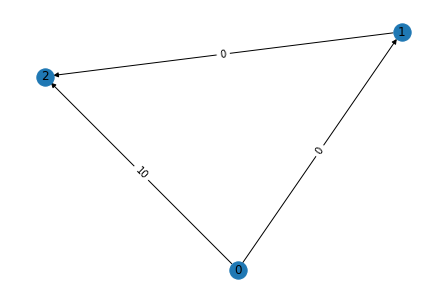

In [ ]:
# test script
sample_workers = [
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None),
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None),
    Worker(memory_size=100, network_bandwidth=10, disk_bandwidth=10, status=WorkerStatus.FREE, failure_rate=0.01, straggle_rate=0.01, task=None)]

workerG = WorkerGraph()
workerG.add_workers(sample_workers)
workerG.request(sample_workers[0], sample_workers[2]) # request 0->2, get 10
workerG.request(sample_workers[1], sample_workers[2]) # request 1->2, get 0 since 2 is using all of its bandwidth

workerG.print_graph()




In [ ]:
scheduler = Scheduler(taskG, sample_workers)
scheduler.simulate()

[0, 1, 2, 3, 4, 5, 6]
debugging graph

task_id:  0
status:  TaskStatus.COMPUTING
num of dependent tasks:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  1
status:  TaskStatus.COMPUTING
num of dependent tasks:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  2
status:  TaskStatus.COMPUTING
num of dependent tasks:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  3
status:  TaskStatus.COMPUTING
num of dependent tasks:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  4
status:  TaskStatus.COMPUTING
num of dependent tasks:  0
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  5
status:  TaskStatus.COMPUTING
num of dependent tasks:  5
parameters:  {'task_type': 'sort', 'n_records': 1000}
task_id:  6
status:  TaskStatus.COMPUTING
num of dependent tasks:  5
parameters:  {'task_type': 'sort', 'n_records': 1000}
starting to work through task_queue.

starting to work through event_queue.

Last event time: 6917.7

In [ ]:
''' class Simulator():

    def __init__(self, s: Scheduler):
        self.scheduler = s 

    
 '''


# DON"T NEED CUZ WE PUT TASKS IN THE  nx.DiGraph dictionary
# class TaskGraph():
#     def __init__(self, task_graph:nx.DiGraph):
#         self.graph = task_graph
#         for 

#         for n in range(len( self.G.nodes)):
#             # TODO: add task_dependencies to TaskGraph()
#             G[n].task_dependencies = G.in_degree(n)
#             if (G[n].task_dependencies == 0):
#                 task_queue.put(G[n]) #add the ready tasks to the queue
#         task_dependencies: List[List[Task]]


' class Simulator():\n\n    def __init__(self, s: Scheduler):\n        self.scheduler = s \n\n    \n '

In [ ]:


def build_task_graph(*task_topology):
    print(type(task_topology))
    extents = nx.utils.pairwise(itertools.accumulate((0,) + task_topology))
    #print(extents)
    layers = [range(start, end) for start, end in extents]
    #print(layers)
    G = nx.DiGraph()
    for (i, layer) in enumerate(layers):
        # list of Task objects
        task_list = [dict(task=Task(task_id=t_id)) for t_id in layer]
        node_list = list(zip(list(layer), task_list))
        print(node_list)
        G.add_nodes_from(node_list, layer=i)
    for layer1, layer2 in nx.utils.pairwise(layers):
        G.add_edges_from(itertools.product(layer1, layer2))
    return G

def debug(g: nx.DiGraph):
    print("debugging graph\n")
    for node in g.nodes:
        g.nodes[node]["task"].debug()

def print_graph(g: nx.DiGraph):
    subset_color = [
        "gold",
        "violet",
        "limegreen",
        "darkorange",
    ]
    color = [subset_color[data["layer"]] for v, data in g.nodes(data=True)]
    pos = nx.multipartite_layout(g, subset_key="layer")
    plt.figure(figsize=(8, 8))
    nx.draw(g, pos, node_color=color, with_labels=False)
    plt.axis("equal")
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=26c72990-d4fd-4f51-a2d1-b4fb7127844f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>